In [1]:
import os
import sys
import subprocess
import shutil
import pickle

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))
import Hyperbolic as hyp
from Main import plot_monoplex_with_ap_removal

# AP code

In [2]:
def find_component(node, connected_components):
    for i, component in enumerate(connected_components):
        if node in component:
            return i
    raise ValueError(f'Component for node {node} not found')

In [3]:
def cascade_remove_links(G):
    keep_going = True
    while keep_going:
        keep_going = False

        clusters_in_layers = [list(nx.connected_components(g)) for g in G]

        for i, g in enumerate(G):
            clusters_to_search = clusters_in_layers[:i] + clusters_in_layers[i + 1:]
            for edge in g.edges():
                if any(find_component(edge[0], clusters) != find_component(edge[1], clusters)
                       for clusters in clusters_to_search):
                    keep_going = True
                    g.remove_edge(*edge)
    
    return G

In [4]:
def articulation_points_multiplex(G):
    ap = set(nx.articulation_points(G[0]))
    return ap.union(*[nx.articulation_points(g) for g in G[1:]])

In [5]:
def max_comp(g):
    return max(nx.connected_components(g), key=len)

In [6]:
def remove_ap(G):
    G = cascade_remove_links(G)

    gcc = max_comp(G[0])
    gcc_size = len(gcc)

    for g in G:
        g.remove_nodes_from([n for n in g if n not in gcc])

    art_points = articulation_points_multiplex(G)

    for g in G:
        g.remove_nodes_from(art_points)

    return G, art_points, gcc_size

# Experiment

In [7]:
kbar = 4.
gamma = 3.
T = .4
N = 5000
nruns = 10

In [8]:
def generate(N, kbar, gamma, T, seed):
    np.random.seed(seed)

    kmin = hyp.CalculateKmin(kbar, gamma)
    print('kmin: ', kmin)

    C = hyp.CalculateC(kbar, T, gamma)
    print('C: ', C)

    R = hyp.CalculateR(N, C)
    print('R: ', R)

    kappa = hyp.SampleKappa(N, kmin, gamma)
    theta = hyp.SampleTheta(N)

    r = hyp.ChangeVariablesFromS1ToH2(N, kappa[:], R, kmin)

    hyp.PrintCoordinates(r[:], theta[:], kappa[:], 'coords.txt')

    subprocess.call(['hyperb.exe', 'coords.txt', str(seed), str(N), str(kbar), str(T)])
    links = hyp.ReadLinks('links.coords.txt')
    return nx.Graph(links), np.array(r), np.array(theta)

In [10]:
def xi_last_iteration(N, kbar, gamma, T, seed):
    G, _, theta = generate(N, kbar, gamma, T, seed)
    while True:
        gcc = max_comp(G)
        G.remove_nodes_from([n for n in G if n not in gcc])
        art_points = list(nx.articulation_points(G))
        G.remove_nodes_from(art_points)
        if not art_points:
            break
    return abs(np.exp(1j * theta[list(gcc)]).sum())

In [11]:
plt.rc('text', usetex=True)
plt.rc('font', size=30, **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['savefig.bbox'] = 'tight'
%matplotlib inline

colors = [
    '#1abc9c',  # turquoise
    '#9b59b6',  # amethyst
    '#34495e',  # wet asphalt
    '#2980b9',  # belize hole
    '#f1c40f',  # sun flower
    '#e74c3c',  # alizarin
    '#7f8c8d',  # asbestos
]

In [12]:
# kbars = [.1] + list(range(1, 13))
# kbars = [.1] + list(range(2, 11, 2))

kbars = np.hstack([
    [.1, 2., 4., 5.],
    np.arange(6., 8. + .05, .05),
    [9., 10., 12.],
])

In [13]:
kbars

array([ 0.1 ,  2.  ,  4.  ,  5.  ,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,
        6.25,  6.3 ,  6.35,  6.4 ,  6.45,  6.5 ,  6.55,  6.6 ,  6.65,
        6.7 ,  6.75,  6.8 ,  6.85,  6.9 ,  6.95,  7.  ,  7.05,  7.1 ,
        7.15,  7.2 ,  7.25,  7.3 ,  7.35,  7.4 ,  7.45,  7.5 ,  7.55,
        7.6 ,  7.65,  7.7 ,  7.75,  7.8 ,  7.85,  7.9 ,  7.95,  8.  ,
        8.05,  9.  , 10.  , 12.  ])

In [16]:
xi_last = {}

seed = 12345
for kbar in kbars:
    xi_last[kbar] = 0.
    for _ in range(nruns):
        xi_last[kbar] += xi_last_iteration(N, kbar, gamma, T, seed)
        seed += 1
    xi_last[kbar] /= nruns

kmin:  0.05
C:  0.029720516134223548
R:  24.066221768275167
number of links:	 235
kmin:  0.05
C:  0.029720516134223548
R:  24.066221768275167
number of links:	 242
kmin:  0.05
C:  0.029720516134223548
R:  24.066221768275167
number of links:	 264
kmin:  0.05
C:  0.029720516134223548
R:  24.066221768275167
number of links:	 255
kmin:  0.05
C:  0.029720516134223548
R:  24.066221768275167
number of links:	 238
kmin:  0.05
C:  0.029720516134223548
R:  24.066221768275167
number of links:	 252
kmin:  0.05
C:  0.029720516134223548
R:  24.066221768275167
number of links:	 280
kmin:  0.05
C:  0.029720516134223548
R:  24.066221768275167
number of links:	 274
kmin:  0.05
C:  0.029720516134223548
R:  24.066221768275167
number of links:	 246
kmin:  0.05
C:  0.029720516134223548
R:  24.066221768275167
number of links:	 233
kmin:  1.0
C:  0.5944103226844709
R:  18.074757221167182
number of links:	 4841
kmin:  1.0
C:  0.5944103226844709
R:  18.074757221167182
number of links:	 4662
kmin:  1.0
C:  0.594

In [14]:
# with open(f'xi_last_{N}.pickle', 'wb') as f:
#     pickle.dump(xi_last, f)

In [14]:
with open(f'xi_last_{N}.pickle', 'rb') as f:
    xi_last = pickle.load(f)

In [30]:
cmax = kbars[np.argmax(list(xi_last.values()))]
cmax

6.799999999999997

In [33]:
ximax = max(xi_last.values())
ximax

894.3555426918623

kmin:  1.0
C:  0.5944103226844709
R:  18.074757221167182
number of links:	 4567

Starting AP removal
AP removal: iteration 1
AP removal: 169 APs
AP removal: iteration 2
AP removal: 4 APs
AP removal: iteration 3
AP removal: 2 APs
AP removal: iteration 4
AP removal: 0 APs
kmin:  3.3999999999999986
C:  2.0209950971272
R:  15.627206357922953
number of links:	 15821

Starting AP removal
AP removal: iteration 1
AP removal: 258 APs
AP removal: iteration 2
AP removal: 182 APs
AP removal: iteration 3
AP removal: 108 APs
AP removal: iteration 4
AP removal: 66 APs
AP removal: iteration 5
AP removal: 38 APs
AP removal: iteration 6
AP removal: 16 APs
AP removal: iteration 7
AP removal: 17 APs
AP removal: iteration 8
AP removal: 6 APs
AP removal: iteration 9
AP removal: 2 APs
AP removal: iteration 10
AP removal: 4 APs
AP removal: iteration 11
AP removal: 0 APs
kmin:  5.5
C:  3.2692567747645898
R:  14.665261036690334
number of links:	 25685

Starting AP removal
AP removal: iteration 1
AP removal: 41 

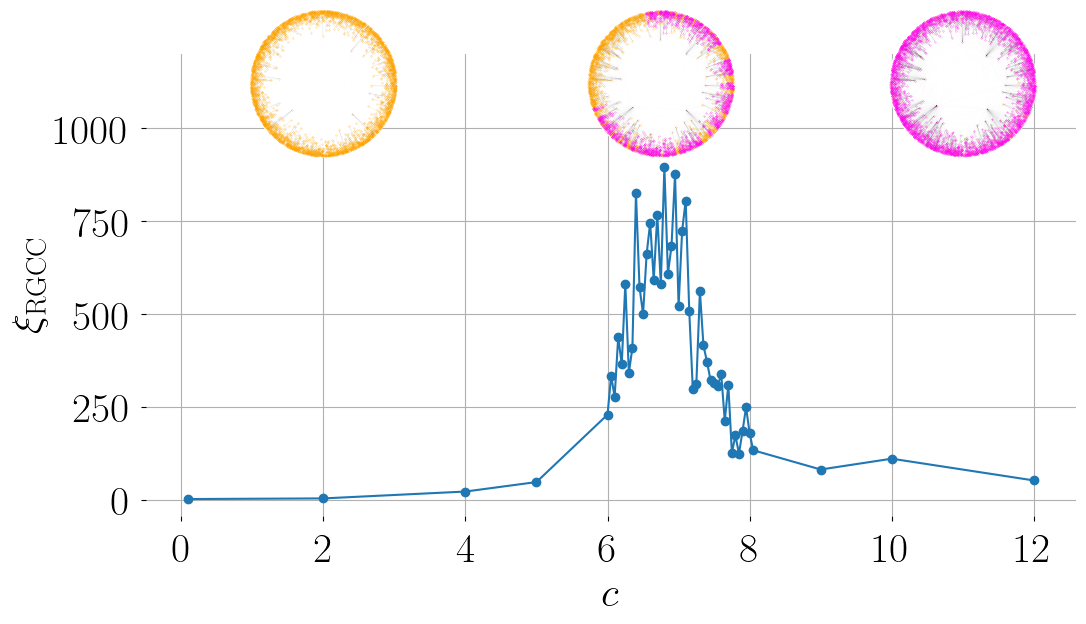

In [64]:
fig, bottom_ax = plt.subplots(figsize=(12, 6))
bottom_ax.plot(
    kbars,
    xi_last.values(),
    'o-',
    ms=6,
    label=None,
)
bottom_ax.set_xlabel(r'$c$')
bottom_ax.set_ylabel(r'$\xi_\mathrm{RGCC}$')
bottom_ax.spines['top'].set_visible(False)
bottom_ax.spines['right'].set_visible(False)
bottom_ax.spines['bottom'].set_visible(False)
bottom_ax.spines['left'].set_visible(False)
bottom_ax.set_xticks(range(0, 12 + 2, 2))
# bottom_ax.set_yticks(range(0, 12 + 2, 2))
bottom_ax.set_ylim(top=1200)
plt.grid()

BRIGHT_MAGENTA = '#ff08e8'
bottom_ax.plot([], [], 'o', color=BRIGHT_MAGENTA, label=r'$\mathrm{RGCC}$')
# plt.legend(loc='right')

inset_axes = []
for c, left in zip([2, cmax, 11], [0, 4.75, 9]):
    inset_axes.append(bottom_ax.inset_axes(
        [left, 920, 4, 400],
        transform=bottom_ax.transData,
        xticklabels=[], yticklabels=[],
        polar=True,
    ))
    plot_monoplex_with_ap_removal(N, gamma, c, T, inset_axes[-1], ms=.2, seed=125467)

In [65]:
fig.savefig('coherence_plot.pdf')

kmin:  0.005
C:  0.002972051613422355
R:  28.671391954263257
number of links:	 20

Starting AP removal
AP removal: iteration 1
AP removal: 0 APs
kmin:  3.3999999999999986
C:  2.0209950971272
R:  15.627206357922953
number of links:	 15821

Starting AP removal
AP removal: iteration 1
AP removal: 258 APs
AP removal: iteration 2
AP removal: 182 APs
AP removal: iteration 3
AP removal: 108 APs
AP removal: iteration 4
AP removal: 66 APs
AP removal: iteration 5
AP removal: 38 APs
AP removal: iteration 6
AP removal: 16 APs
AP removal: iteration 7
AP removal: 17 APs
AP removal: iteration 8
AP removal: 6 APs
AP removal: iteration 9
AP removal: 2 APs
AP removal: iteration 10
AP removal: 4 APs
AP removal: iteration 11
AP removal: 0 APs
kmin:  6.0
C:  3.5664619361068253
R:  14.491238282711073
number of links:	 28027

Starting AP removal
AP removal: iteration 1
AP removal: 22 APs
AP removal: iteration 2
AP removal: 9 APs
AP removal: iteration 3
AP removal: 2 APs
AP removal: iteration 4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AP removal: 4 APs
AP removal: iteration 5
AP removal: 0 APs


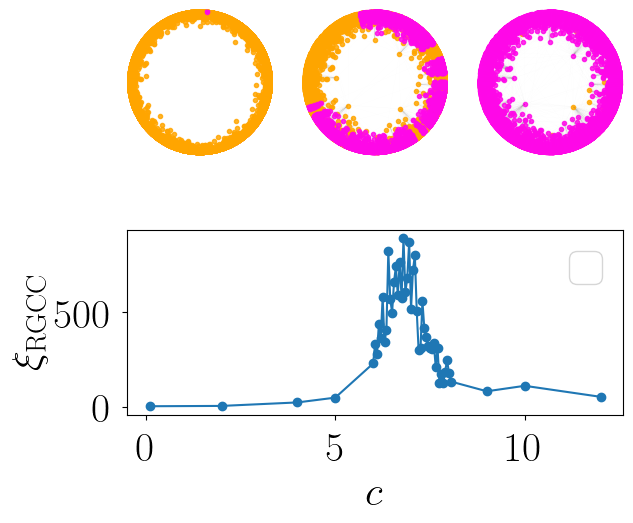

In [31]:
fig = plt.figure()
sf1, sf2 = fig.subfigures(nrows=2, ncols=1)

polar_axes = sf1.subplots(nrows=1, ncols=3, subplot_kw=dict(projection='polar'))
for c, ax in zip([.01, cmax, 12], polar_axes):
    plot_monoplex_with_ap_removal(N, gamma, c, T, ax, ms=3, seed=125467)

bottom_ax = sf2.subplots()
bottom_ax.plot(
    kbars,
    xi_last.values(),
    'o-',
    ms=6,
    label=None,
)
bottom_ax.set_xlabel(r'$c$')
bottom_ax.set_ylabel(r'$\xi_\mathrm{RGCC}$')
plt.legend();

kmin:  5.0
C:  2.9720516134223542
R:  14.855881396298983
number of links:	 23314

Starting AP removal
AP removal: iteration 1
AP removal: 59 APs
AP removal: iteration 2
AP removal: 20 APs
AP removal: iteration 3
AP removal: 4 APs
AP removal: iteration 4
AP removal: 0 APs


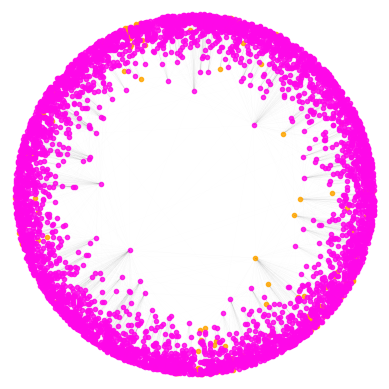

In [21]:
_, ax = plt.subplots(subplot_kw=dict(projection='polar'))
plot_monoplex_with_ap_removal(N, gamma, 10, T, ax, ms=3, seed=125467)